This is the code that is used to generate the SERA demand inputs and network links

 - Starting with the latest STIEVE inputs (taz demands)
 - remove the smallest TAZ demands and consolidate them to the nearest TAZ
 - use k-means clusters to futher group the TAZs into larger TAZs
 - map (using Folium) the old and new TAZ locations 
 - generate the new SERA demands input file
 - generate all candidate networks (using delaunay and gabriel algorithms)
 - write the new SERA links file 
 
 - added new plant locations (Aug 2023) so some of the code is being modified

In [1]:
#####
## Library loads
#####
import geopy.distance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
import folium
import geopandas
import geopy.distance
import copy
from scipy.spatial import Delaunay
import math

In [2]:
####
# LOAD TAZ STIEVE CSV
###
df = pd.read_csv('fuelingByRegion_all_high.csv')
# df = pd.read_excel("CA_StatDemandsHigh.xls",sheet_name="taz")
print(len(df))
# display(df)
df=pd.pivot_table(df, values = 'fueling', index=['TAZ12','Lon','Lat'], columns = 'year').reset_index()
df=df.sort_values(by=[2050])
tazdem = df.rename_axis(None, axis=1)
tazdem['Notes']=""
origtazdem=tazdem.copy(deep=True)
###
df

1968


year  TAZ12         Lon        Lat         2025          2030           2035  \
21      171 -123.261944  40.884961     0.222772      7.356112      31.444402   
274    3350 -119.745916  34.442780          NaN           NaN            NaN   
208    2603 -120.081394  35.903519          NaN           NaN            NaN   
196    2520 -119.780426  36.547830          NaN           NaN            NaN   
56      345 -121.380664  39.146241    86.921828    500.000000            NaN   
..      ...         ...        ...          ...           ...            ...   
221    2824 -118.931122  35.327213   484.956656    500.000000   20000.000000   
332    5110 -117.123059  34.939779          NaN  37609.266590   40000.000000   
334    5112 -117.113521  34.830770          NaN           NaN            NaN   
331    5101 -117.283559  35.385943  5213.195478  20000.000000   20000.000000   
359    5195 -116.440649  34.844995   347.835790  19542.885750  188287.269300   

year           2040          2045           2050  
21        72.066620     112.85854     144.488869  
274             NaN           NaN     380.301082  
208      500.000000     500.00000     500.000000  
196      384.426636     500.00000     500.000000  
56       500.000000           NaN     500.000000  
..              ...           ...            ...  
221    91997.465180  200000.00000  200000.000000  
332    40000.000000   40000.00000  256794.326900  
334             NaN  254937.97450  260000.000000  
331   271960.619800  280000.00000  280000.000000  
359   340000.000000  620000.00000  760000.000000  

[506 rows x 9 columns]

In [3]:
####
# MAKE DISTANCE MATRIX FOR ALL TAZS
###
df['coord']=list(zip(df['Lat'],df['Lon']))

listofcoord=list(df['coord'])
tazmatrix=df[['TAZ12','coord']]
listoftazs=list(tazmatrix['TAZ12'])
listofcols=['TAZ12','coord']+listoftazs
tazmatrix=tazmatrix.reindex(columns=listofcols, fill_value=0)

print(len(listofcoord))
print(len(listoftazs))
print(len(df))

for i in range(0,len(df)):
    for j in range(i+1,len(df)):
        # print(i,j)
        tmpdist=geopy.distance.geodesic(listofcoord[i], listofcoord[j]).km
        tazmatrix[listoftazs[j]].iloc[i]=tmpdist
        tazmatrix[listoftazs[i]].iloc[j]=tmpdist
tazmatrix=tazmatrix.reset_index()

origtazmatrix=tazmatrix.copy(deep=True)
#####  tazmatrix is the df matrix of all the distances between TAZs


tazmatrix

506
506
506


/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_6694/551868017.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tazmatrix[listoftazs[j]].iloc[i]=tmpdist
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_6694/551868017.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '779.2302784167184' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tazmatrix[listoftazs[j]].iloc[i]=tmpdist
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_6694/551868017.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

year  index  TAZ12                        coord         171        3350  \
0        21    171   (40.8849613, -123.2619437)    0.000000  779.230278   
1       274   3350   (34.4427798, -119.7459158)  779.230278    0.000000   
2       208   2603  (35.90351937, -120.0813937)  618.724297  164.915877   
3       196   2520  (36.54782955, -119.7804262)  568.641087  233.575653   
4        56    345  (39.14624054, -121.3806637)  251.119796  541.939993   
..      ...    ...                          ...         ...         ...   
501     221   2824  (35.32721281, -118.9311217)  724.222008  123.185974   
502     332   5110  (34.93977875, -117.1230595)  852.071916  246.566263   
503     334   5112  (34.83076964, -117.1135206)  862.230436  245.163381   
504     331   5101  (35.38594263, -117.2835587)  804.105975  248.144956   
505     359   5195  (34.84499495, -116.4406487)  899.227645  306.285552   

year        2603        2520         345         172        3034  ...  \
0     618.724297  568.641087  251.119796   44.152085  422.732032  ...   
1     164.915877  233.575653  541.939993  738.614364  374.770659  ...   
2       0.000000   76.443790  377.769689  579.211861  209.926603  ...   
3      76.443790    0.000000  320.944989  531.351864  147.933661  ...   
4     377.769689  320.944989    0.000000  218.172452  173.298771  ...   
..           ...         ...         ...         ...         ...  ...   
501   122.265401  155.614177  476.275851  686.700646  303.008005  ...   
502   289.147017  299.330097  600.991015  818.284918  432.628221  ...   
503   294.790386  307.495551  611.119426  828.214148  442.209292  ...   
504   259.805103  259.495339  553.247698  771.028988  386.898750  ...   
505   351.034123  356.429094  648.800048  866.852725  483.910791  ...   

year         6518        2129        2212        3987         5669  \
0     1057.011638  393.310040  398.698198  867.542467  1116.475082   
1      312.242074  386.922818  382.098136  140.460635   481.103694   
2      446.104600  225.424324  220.056885  255.369546   562.171012   
3      488.389713  181.811777  175.263914  299.194970   574.722132   
4      808.184960  158.826694  162.306538  620.002284   866.816718   
..            ...         ...         ...         ...          ...   
501    332.918399  334.911873  328.710866  143.740162   440.480302   
502    240.436759  479.277356  472.445846  135.815375   275.686719   
503    228.321441  487.986732  481.191154  129.178474   268.424211   
504    290.697103  436.521151  429.577138  163.105313   317.013805   
505    236.320336  534.018814  527.075130  183.718485   219.588042   

year        2824        5110        5112        5101        5195  
0     724.222008  852.071916  862.230436  804.105975  899.227645  
1     123.185974  246.566263  245.163381  248.144956  306.285552  
2     122.265401  289.147017  294.790386  259.805103  351.034123  
3     155.614177  299.330097  307.495551  259.495339  356.429094  
4     476.275851  600.991015  611.119426  553.247698  648.800048  
..           ...         ...         ...         ...         ...  
501     0.000000  170.296880  174.672680  149.887586  233.320868  
502   170.296880    0.000000   12.124702   51.613655   63.257427  
503   174.672680   12.124702    0.000000   63.513146   61.566261  
504   149.887586   51.613655   63.513146    0.000000   97.498008  
505   233.320868   63.257427   61.566261   97.498008    0.000000  

[506 rows x 509 columns]

In [4]:
####
# consolidate TAZs with small demands
#####

threshold = 1000
# find the TAZs with small demands in 2050
smalltazlist=list(df[df[2050]<threshold]['TAZ12'])
print(len(smalltazlist),"small TAZs to add to next closest TAZ")
# ",".join([str(i) for i in smalltazlist])


22 small TAZs to add to next closest TAZ


In [5]:
#####
##TAZ consolidation so small tazs below threshold size are added to nearest one
#####
tazmatrix=origtazmatrix.copy(deep=True)
tazdem=origtazdem.copy(deep=True)
tazdem=tazdem.fillna(0)
# Rows are the TO element and columns to the right are the FROM element
# if we remove all small TAZ rows we can find TAZs that are closest to the small TAZ (col)

for taz in smalltazlist:
    tazmatrix = tazmatrix[tazmatrix['TAZ12'] != taz]
print(origtazmatrix.shape,tazmatrix.shape)

yrs=[2025,2030,2035,2040,2045,2050]

# go through list of small tazs and then look at the column for the TAZ in question
# sort it from low to high and the next row (after it's own row) is the closest TAZ.
# add the small TAZ's demands to this row in the 
for smalltaz in smalltazlist:
    tazmatrix=tazmatrix.sort_values(by=[smalltaz])
    # display(tazmatrix.iloc[0:2,:])
    closesttaz=tazmatrix['TAZ12'].iloc[1]
    dist=tazmatrix[smalltaz].iloc[1]
    
    ftpair=[smalltaz,closesttaz] #from/to pair
    print(closesttaz, "is the closest to", smalltaz,"-", dist,"km away")
    
    # pair=[171,109]
    for yr in yrs:
        tazdem.loc[tazdem['TAZ12'] == ftpair[1], yr]+=float(tazdem.loc[tazdem['TAZ12'] == ftpair[0], yr])
    tazdem.loc[tazdem['TAZ12'] == ftpair[1], 'Notes']=ftpair[0]
    tazdem=tazdem[tazdem['TAZ12']!=ftpair[0]]
    print(len(tazdem))

(506, 509) (484, 509)
109 is the closest to 171 - 51.135955324008755 km away
505
3362 is the closest to 3350 - 39.125720221188516 km away
504
2530 is the closest to 2603 - 29.399380914155227 km away
503
2489 is the closest to 2520 - 12.880718473221615 km away
502
446 is the closest to 345 - 20.766110057508687 km away
501
170 is the closest to 172 - 62.162326366390566 km away
500
3019 is the closest to 3034 - 29.69597651378527 km away
499
165 is the closest to 163 - 56.66215600118925 km away
498
2935 is the closest to 2913 - 19.828524439276727 km away
497
2904 is the closest to 2934 - 31.520699542368963 km away
496
309 is the closest to 227 - 24.840986142141 km away
495
122 is the closest to 130 - 79.43691681034123 km away
494
2507 is the closest to 3022 - 72.88240620950582 km away
493
256 is the closest to 257 - 28.327637865979494 km away
492
3324 is the closest to 3300 - 38.065720384104594 km away
491
251 is the closest to 247 - 56.93842982687085 km away
490
434 is the closest to 460 

/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_6694/1164307136.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tazdem.loc[tazdem['TAZ12'] == ftpair[1], yr]+=float(tazdem.loc[tazdem['TAZ12'] == ftpair[0], yr])


2742 is the closest to 2703 - 19.523334612001488 km away
488
1584 is the closest to 923 - 14.868865679193197 km away
487
278 is the closest to 276 - 49.49307926783394 km away
486
248 is the closest to 246 - 50.34350256530555 km away
485
3101 is the closest to 3213 - 30.44688722097381 km away
484


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

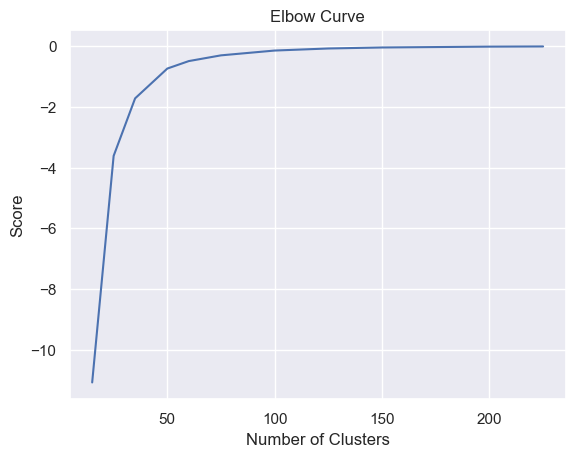

In [6]:
#####
# K_means elbow analysis - try different cluster number and see which number leads to small
# error while reducing number significantly
###
K_clusters = [15,25,35,50,60,75,100,125,150,200,225]
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = tazdem[['Lat']]
X_axis = tazdem[['Lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [7]:
#####
##. This section uses the kmeans algorithm to cluster the TAZs
## specify the number of clusters to use
## output in tazdem tells you which cluster each TAZ belongs to
###
targetTAZ=484

Ncluster=targetTAZ

tazdem['Ntaz']=1
tazdem=tazdem.sort_values(2050, ascending=False)
kmeans = KMeans(n_clusters = Ncluster, init ='k-means++')
kmeans.fit(tazdem[tazdem.columns[1:3]]) # Compute k-means clustering.
tazdem['cluster_label'] = kmeans.fit_predict(tazdem[tazdem.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(tazdem[tazdem.columns[1:3]]) # Labels of each point
tazdem

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


TAZ12         Lon        Lat         2025          2030           2035  \
359   5195 -116.440649  34.844995   347.835790  19542.885750  188287.269300   
331   5101 -117.283559  35.385943  5213.195478  20000.000000   20000.000000   
334   5112 -117.113521  34.830770     0.000000      0.000000       0.000000   
332   5110 -117.123059  34.939779     0.000000  37609.266590   40000.000000   
221   2824 -118.931122  35.327213   484.956656    500.000000   20000.000000   
..     ...         ...        ...          ...           ...            ...   
26     228 -122.357841  39.219097     0.000000     59.489818    1403.888958   
89     803 -122.304670  38.626594    18.428473    351.006483     238.509634   
37     258 -123.198120  38.962839    19.582220    266.494117     500.000000   
254   3021 -119.203394  38.167137     8.770010    213.941687     770.765579   
257   3030 -119.691849  37.943261    16.877493    454.452821     475.785392   

             2040           2045           2050 Notes  Ntaz  cluster_label  
359  340000.00000  620000.000000  760000.000000           1            107  
331  271960.61980  280000.000000  280000.000000           1             38  
334       0.00000  254937.974500  260000.000000           1            121  
332   40000.00000   40000.000000  256794.326900           1            321  
221   91997.46518  200000.000000  200000.000000           1            410  
..            ...            ...            ...   ...   ...            ...  
26     1500.00000    1500.000000    1500.000000           1             62  
89      750.00000     911.897645    1484.274195           1            231  
37      500.00000    1000.000000    1023.079203           1            150  
254    1000.00000     801.613247    1000.000000           1             92  
257     500.00000    1000.000000    1000.000000           1             16  

[484 rows x 12 columns]

In [8]:
####
# Kmeans indicates which cluster each TAZ belongs to
# then we groupby by the cluster names which reduces the number
# and sum the demands (assigning the clusters to the largest TAZ in each cluster
###
tazdem2=tazdem.copy(deep=True)
tazdem2['Names']=tazdem2['TAZ12'].astype(str)+" "+tazdem2['Notes'].astype(str) #df["Year"].astype(str) + df["quarter"]
tazdem2=tazdem2.groupby('cluster_label', as_index=False).agg({'TAZ12':'first', 'Lat':'first', 'Lon':'first',2025:'sum',2030:'sum',2035:'sum',2040:'sum',2045:'sum',2050:'sum','Ntaz':'sum','Names':','.join})
# df2['Names']=df2['Names'].str.replace("\n"," ")
# tazdem2

In [9]:
orighublocations=[531,1408,2312,2947,4619,6424]
hublocations= [534,1480,2312,2947,4619,6412]
hubclusters=[]
for i in range(len(hublocations)):
    cluster=tazdem[tazdem['TAZ12']==hublocations[i]].iloc[0]['cluster_label']
    hubclusters.append(cluster)
print(hubclusters)

######
# ADD HUBS Demand?
# this section looks at 6 hubs that Vishnu used and determines which of the demand clusters
# the hubs shoudl go in (since the taz clustering may have a different name than the the 
# hub TAZ
####
ADDHUBS=False
#####
if ADDHUBS==True:
    print('true')
    hubdemands = pd.read_csv('hub demands.tsv',sep='\t')
    hubdemands['TAZ']=hubdemands['Network ID'].str.replace("TAZ_","")
    display(hubdemands)
    hubtazs=list(tazdem2[tazdem2['cluster_label'].isin(hubclusters)]['TAZ12'].unique())
    hubtazs.sort()
    display(hubtazs)


[479, 256, 315, 20, 402, 18]


In [10]:
###########
#### Interpolate the columns to get demand for each and every year
#### melt dataframe from wide to make long
#### make dataframe fit the SERA demand inputs file format and export to tsv
######
tazdem3=tazdem2.copy(deep=True)
tazdem3=tazdem3[['TAZ12',2025,2030,2035,2040,2045,2050]]
toadd=list(range(2025,2051))
for i in toadd:
    if i not in yrs:
        tazdem3[i]=np.nan
tazdem3=tazdem3[['TAZ12']+toadd]
tazdem4=tazdem3.interpolate(axis=1)
tazdem4['TAZ12']=tazdem4['TAZ12'].astype(int)
# tazdem4=tazdem4.rename({'TAZ12':'Network ID'})
tazdem4.rename({'TAZ12':'Network ID'}, axis=1, inplace=True)
tazdem4['Network ID']="TAZ_"+tazdem4['Network ID'].astype(str)
# print(len(tazdem4))
# display(tazdem4)

tazdemlong= pd.melt(tazdem4, id_vars='Network ID', value_vars=list(range(2025,2051)))
tazdemlong = tazdemlong.rename({'value': 'Fueling-Station Demand [kg]','variable':'Year'}, axis='columns')
tazdemlong=tazdemlong[tazdemlong['Fueling-Station Demand [kg]']>0]
tazdemlong['Period']='1 Year'
othercols=['Ammonia [kg]','Biofuels [kg]','Methanol [kg]','FT Fuels [kg]','Metals [kg]','Natural Gas Blending [kg]','Seasonal Grid Storage [kg]','Other [kg]']
for coln in othercols:
    tazdemlong[coln]=0
        
#### convert fueling kg/day to kg/yr
tazdemlong['Fueling-Station Demand [kg]']=round(tazdemlong['Fueling-Station Demand [kg]']*365*100)/100
# tazdemlong['Network ID']="TAZ_"+tazdemlong['Network ID'].astype(str)

#### Add in Hub demands
if ADDHUBS==True:

    for i in range(len(hubdemands)):
        oldtaz=int(hubdemands.loc[i,'TAZ'])
        yr=int(hubdemands.loc[i,'Year'])
        clusterindex=hublocations.index(oldtaz)
        newtaz="TAZ_"+str(hubtazs[clusterindex])
        # print(yr, newtaz,hubdemands.loc[i,'Other [kg]'])
        tazdemlong.loc[(tazdemlong['Network ID']==newtaz) & (tazdemlong['Year']==yr),'Other [kg]']=hubdemands.loc[i,'Other [kg]']
    demfilename='newdemand_hubs_'+str(targetTAZ)+'TAZ.tsv'
else:
    demfilename='newdemand_newLoc_'+str(targetTAZ)+'TAZ.tsv'
tazdemlong=tazdemlong[['Network ID','Year','Period','Fueling-Station Demand [kg]','Ammonia [kg]','Biofuels [kg]','Methanol [kg]','FT Fuels [kg]','Metals [kg]','Natural Gas Blending [kg]','Seasonal Grid Storage [kg]','Other [kg]']]



tazdemlong.to_csv(demfilename, sep = '\t',index=False)
# display(hubdemands)
tazdemlong

Network ID  Year  Period  Fueling-Station Demand [kg]  Ammonia [kg]  \
0        TAZ_226  2025  1 Year                      5323.96             0   
1       TAZ_4916  2025  1 Year                    182500.00             0   
2       TAZ_2227  2025  1 Year                   1825000.00             0   
4       TAZ_2949  2025  1 Year                     49776.78             0   
5       TAZ_1672  2025  1 Year                    226602.76             0   
...          ...   ...     ...                          ...           ...   
12579    TAZ_534  2050  1 Year                   7300000.00             0   
12580   TAZ_6518  2050  1 Year                  56979698.46             0   
12581   TAZ_6024  2050  1 Year                   7300000.00             0   
12582   TAZ_4414  2050  1 Year                   7300000.00             0   
12583    TAZ_546  2050  1 Year                   7300000.00             0   

       Biofuels [kg]  Methanol [kg]  FT Fuels [kg]  Metals [kg]  \
0                  0              0              0            0   
1                  0              0              0            0   
2                  0              0              0            0   
4                  0              0              0            0   
5                  0              0              0            0   
...              ...            ...            ...          ...   
12579              0              0              0            0   
12580              0              0              0            0   
12581              0              0              0            0   
12582              0              0              0            0   
12583              0              0              0            0   

       Natural Gas Blending [kg]  Seasonal Grid Storage [kg]  Other [kg]  
0                              0                           0           0  
1                              0                           0           0  
2                              0                           0           0  
4                              0                           0           0  
5                              0                           0           0  
...                          ...                         ...         ...  
12579                          0                           0           0  
12580                          0                           0           0  
12581                          0                           0           0  
12582                          0                           0           0  
12583                          0                           0           0  

[8668 rows x 12 columns]

In [11]:
#####
# Make a Folium (leaflet) map of the original taz and the new clustered TAZs
# and save the interactive map
#####

map = folium.Map(location=[origtazdem.Lat.mean(), df.Lon.mean()], 
                 # width=300,height=400,
                 tiles="cartodbpositron", zoom_start=5, control_scale=True)
map
lat=list(origtazdem.Lat)
lon=list(origtazdem.Lon)
size=list(origtazdem.loc[:,2050])
names=list(origtazdem.TAZ12)

feature_group=folium.FeatureGroup('original')
for i in range(len(origtazdem)):
   
    folium.Circle(
        radius=10*size[i]**.5,
        location=[lat[i], lon[i]],
        popup=str(names[i])+"-"+str(round(size[i])),
        color="blue",
        fill_color="blue",
        fill_opacity=1,
        fill=True,
    ).add_to(feature_group)
    
feature_group.add_to(map)


lat2=list(tazdem2.Lat)
lon2=list(tazdem2.Lon)
size2=list(tazdem2.loc[:,2050])
names2=list(tazdem2.Names)
Ntaz=list(tazdem2.Ntaz)

feature_group=folium.FeatureGroup('clustered')
for i in range(len(tazdem2)):
    if Ntaz[i]>1:
        outcolor="darkred"
    else: 
        outcolor="red"
    folium.Circle(
        radius=10*size2[i]**.5,
        location=[lat2[i], lon2[i]],
        popup=str(Ntaz[i])+" taz\n"+str(round(size2[i]))+" kg/d\ntaz#\n"+str(names2[i]),
        color=outcolor,
        fill=True,
        fill_opacity=1,
    ).add_to(feature_group)
feature_group.add_to(map)
folium.LayerControl().add_to(map)

map.save('TAZ_newLoc_'+str(targetTAZ)+'.html')
map

In [15]:
##### make links / geography file for SERA inputs
## open old sera geometry file and extract WECC and Cavern locations
## i will make new link and TAZ locations
#####
WECC_inCA=[ 'WECC_IID', 'WECC_SCE', 'WECC_SF',  'WEC_CALN', 'WEC_LADW', 'WEC_SDGE', 'PL_CA1','PL_CA2','PL_CA3','PL_CA4','PL_CA5','PL_CA6','PL_CA7']
WECC_outCA=['WECC_AZ', 'WECC_CO', 'WECC_ID', 'WECC_MT', 'WECC_NM', 'WECC_NNV', 'WECC_PNW', 'WECC_SNV', 'WECC_UT', 'WECC_WY','PL_NV1','PL_AZ1']

inCAonly=False

oldgeopath= '../../Exe_prodCF_NG_5/outputs/GEOMETRY/geometry_high.tsv'
#'../SERA/SERA_NEW_OUTPUTS/BASECASE_CY_5_AB3C4D/outputs/GEOMETRY/geometry_high.tsv'
# folder='../SERA/SERA_NEW_OUTPUTS/BASECASE_CY_5_AB3C4D/'
newgeopath= '../../Exe_prodCF_NG_5/outputs/GEOMETRY/geometry_high.tsv'
#'../SERA/geometry_high_newLoc.tsv'


oldserageo=pd.read_csv(newgeopath, sep='\t')
oldserageo['Type']=oldserageo['Network ID'].str[0:3]
# print(oldserageo['Type'].value_counts())
keep=oldserageo[(oldserageo['Type']=="Cav") | (oldserageo['Type']=="WEC") | (oldserageo['Type']=="PL_")]
keep=keep.reset_index(drop=True)
if inCAonly:
    keep=keep[keep['Network ID'].isin(WECC_inCA)]
# display(keep)

serageo_new=keep.copy(deep=True).reset_index(drop=True)
for i in range(len(tazdem4)):
    # print(i)
    tazrow=tazdem2.loc[i,:]
    serageo_new.loc[len(serageo_new.index)] = ["TAZ_"+str(tazrow['TAZ12']), 'center', tazrow["Lon"],tazrow["Lat"],'TAZ'] 

print(len(keep),len(serageo_new))
# serageo_new

41 525


In [16]:
serageo_new[serageo_new['Network ID'].str.contains("PL_")]

Empty DataFrame
Columns: [Network ID, Position, X, Y, Type]
Index: []

In [17]:
#####
# Create Delaunay triangles from caves, WECC centers and TAZs
#####

def order_ascend(a, b):
    return [a,b] if a < b else [b,a]

def dist(a,b):
    return math.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)

xs=list(serageo_new['X'])
ys=list(serageo_new['Y'])

points=[[xs[i],ys[i]] for i in range(0,len(xs))]
points=np.array(points)
tri = Delaunay(points)

# plt.figure(figsize=(20,15))
# plt.triplot(points[:,0], points[:,1], tri.simplices)
# # plt.plot(points[:,0], points[:,1], 'o')
# plt.show()


full_list_of_edges=[]
list_of_edges=[]
list_of_edges_indices=[]
for triangle in tri.simplices:
    # print(triangle)
    for p1,p2 in [[0,1],[1,2],[2,0]]:
        edge_indices=order_ascend(triangle[p1],triangle[p2])
        # print(edge_indices,end=" ")
        # print(points[edge_indices[0]],points[edge_indices[1]])
        full_list_of_edges.append([edge_indices,points[edge_indices[0]].tolist(),points[edge_indices[1]].tolist()])
        if edge_indices not in list_of_edges_indices:
            list_of_edges.append([edge_indices,points[edge_indices[0]].tolist(),points[edge_indices[1]].tolist()])
            list_of_edges_indices.append(edge_indices)
print("Number of unique edges",len(list_of_edges))

# algorithm="Gabriel"
# algorithm="Urquhart"
algorithm="Both"

pointslist=points.tolist()
reduced_list_of_edges=[]
removed_edges=[]
############Gabriel###############
if algorithm=="Gabriel" or algorithm=="Both":
    for edge in list_of_edges:
    # print(edge)
        p1=edge[1]
        p2=edge[2]
        center=[(p1[0]+p2[0])/2,(p1[1]+p2[1])/2]
        rad=dist(center,p1)-.0001 #rad is the radius of the circle between points 1 and 2 of an existing edge 
        # print(p1,p2,center,rad)
        #get list of points in bounding box of center of circle
        inside2=[point for point in pointslist if dist(point,center)<rad]
        #if there are points inside, don't add this edge to the save list
        if len(inside2)>0:
        #     reduced_list_of_edges.append(edge)
            removed_edges.append(edge)
    print(len(removed_edges)," removed after Gabriel")
############Urquhart###############
if algorithm=="Urquhart" or algorithm=="Both":
    threshold=.75 #degree
    removemax=False
    if algorithm=="Urquhart":
        removed_edges=[]
    for i in range(0,len(full_list_of_edges),3):
        side_lengths=[]
        for j in range(0,3):
            side_lengths.append(dist(full_list_of_edges[i+j][1],full_list_of_edges[i+j][2]))
        maxside=max(side_lengths)
        if maxside<threshold: ## only remove longest edges that are smaller than threshold
            maxind=side_lengths.index(maxside)
            removemax=True
        else:
            removemax=False
            maxind=4
        for j in range(0,3):
            if j==maxind and removemax==True:
                removed_edges.append(full_list_of_edges[i+j])
            # else:
            #     reduced_list_of_edges.append(full_list_of_edges[i+j])

removed_edges            
# removed_edge_list=list(map(lambda x: x[0],removed_edges))
removed_edge_list=[x[0] for x in removed_edges]
# removed_edge_list
added_edges=[]
for i in range(len(full_list_of_edges)):
    if full_list_of_edges[i][0] not in removed_edge_list and full_list_of_edges[i][0] not in added_edges:
        reduced_list_of_edges.append(full_list_of_edges[i])
        added_edges.append(full_list_of_edges[i][0])

    
print(len(list_of_edges),len(reduced_list_of_edges),len(reduced_list_of_edges)/len(list_of_edges))

# fig = plt.figure(figsize=(12,8))
# ax = plt.axes()
# for i in range(len(reduced_list_of_edges)):
#     edge=reduced_list_of_edges[i]
#     x=[edge[1][0],edge[2][0]]
#     y=[edge[1][1],edge[2][1]]
#     ax.plot(x,y,c='b')
    
maplinks = folium.Map(location=[origtazdem.Lat.mean(), df.Lon.mean()], 
                 # width=300,height=400,
                 tiles="cartodbpositron", zoom_start=5, control_scale=True)
maplinks

feature_group=folium.FeatureGroup('original')

for i in range(len(list_of_edges)):
    coord1=(list_of_edges[i][1][1],list_of_edges[i][1][0])
    coord2=(list_of_edges[i][2][1],list_of_edges[i][2][0])
    lineseg = [
        coord1, coord2
    ]
    folium.PolyLine(lineseg, weight=1,color="blue",tooltip="link_"+("0000"+str(i+1))[-4:]).add_to(feature_group)
feature_group.add_to(maplinks)

feature_group=folium.FeatureGroup('reduced')
for i in range(len(reduced_list_of_edges)):
    coord1=(reduced_list_of_edges[i][1][1],reduced_list_of_edges[i][1][0])
    coord2=(reduced_list_of_edges[i][2][1],reduced_list_of_edges[i][2][0])
    redlineseg = [
        coord1, coord2
    ]
    folium.PolyLine(redlineseg, weight=1,color="red",tooltip="link_"+("0000"+str(i+1))[-4:]).add_to(feature_group)
feature_group.add_to(maplinks)
folium.LayerControl().add_to(maplinks)

maplinks.save('Links_CAonly_'+str(targetTAZ)+'.html')
maplinks

Number of unique edges 1556
539  removed after Gabriel
1556 702 0.45115681233933164


In [18]:
### Make new geometry file

lr=['left','right']
print(len(serageo_new))
serageo_new2=serageo_new.copy(deep=True)
k=len(serageo_new2.index)
print(k)
for i in range(len(reduced_list_of_edges)):
    edge=reduced_list_of_edges[i]
    linkname="link_"+("000"+str(i+1))[-4:]
    # print(linkname)
    coords=[edge[1],edge[2]]
    for j in range(len(lr)):
        side=lr[j]
        lon=coords[j][0]
        lat=coords[j][1]
        serageo_new2.loc[k] = [linkname, side, lon,lat,'link'] 
        # print(k)
        k+=1

print(len(serageo_new2))
serageo_new2=serageo_new2.drop(columns=['Type'])
serageo_new2.to_csv('new'+str(targetTAZ)+'_newLoc_geometry.tsv', sep = '\t',index=False)
#link_<num>    right/left.    Lon.   Lat.  link

525
525
1929


In [19]:
######
##  Updating Nodes file for SERA
######

nodes = pd.read_csv('nodes_newPlantsTAZ.tsv',sep='\t')
nodes = nodes[(nodes['Network ID'].str.contains("WEC")) | (nodes['Network ID'].str.contains("Cav")) | (nodes['Network ID'].str.contains("PL_"))]
if inCAonly:
    nodes= nodes[nodes['Network ID'].isin(WECC_inCA)]
nodes=nodes.reset_index(drop=True)
display(nodes)

# nodes.loc[len(nodes)-1,:]
# TAZ_6554	-116.926930	32.803945	0	No	0	0	0
print(len(nodes))
lennodes=len(nodes.index)
for i in range(len(tazdem2)):
    tazrow=tazdem2.loc[i]
    # display(tazrow)
    # print(len(nodes.index), end=" ")
    # print(['TAZ_'+str(tazrow['TAZ12']),tazrow['Lon'],tazrow['Lat'],0,'No',0,0,0])
    nodes.loc[lennodes+i]=['TAZ_'+str(tazrow['TAZ12']),tazrow['Lon'],tazrow['Lat'],0,'No',0,0,0]
    
nodes
print(len(nodes))
nodes.to_csv('nodes_new'+str(targetTAZ)+'_newLoc_TAZ.tsv', sep = '\t',index=False)

Network ID           X          Y  Area [km^2] Production?  Cost [$]  \
0     WECC_AZ -111.660286  34.277130            0     Central         0   
1     WECC_CO -105.547730  38.996526            0     Central         0   
2     WECC_ID -114.329874  43.797694            0     Central         0   
3    WECC_IID -115.365361  33.039938            0          No         0   
4     WECC_MT -111.015495  46.972129            0     Central         0   
5     WECC_NM -106.498997  34.464434            0     Central         0   
6    WECC_NNV -116.765406  39.574022            0     Central         0   
7    WECC_PNW -120.326967  45.247587            0     Central         0   
8    WECC_SCE -115.746324  34.631584            0          No         0   
9     WECC_SF -121.780622  37.535963            0          No         0   
10   WECC_SNV -115.018814  36.213199            0     Central         0   
11    WECC_UT -111.670489  39.305164            0     Central         0   
12    WECC_WY -107.148099  43.040226            0     Central         0   
13   WEC_CALN -122.855914  39.934818            0          No         0   
14   WEC_LADW -118.217191  34.361337            0          No         0   
15   WEC_SDGE -116.732513  33.035913            0          No         0   
16     PL_CA1 -117.951000  34.834000            0     Central         0   
17     PL_CA2 -119.275000  35.279000            0     Central         0   
18     PL_CA3 -119.973000  36.055000            0     Central         0   
19     PL_CA4 -120.995000  37.043000            0     Central         0   
20     PL_CA5 -120.987000  37.990000            0     Central         0   
21     PL_CA6 -122.149000  39.875000            0     Central         0   
22     PL_CA7 -122.392000  40.383000            0     Central         0   
23     PL_NV1 -119.501000  39.493000            0     Central         0   
24     PL_AZ1 -113.086000  33.591000            0     Central         0   
25   Cavern_0 -106.287300  45.422900            0          No         0   
26   Cavern_1 -105.807100  44.869800            0          No         0   
27   Cavern_2 -103.108300  39.914400            0          No         0   
28   Cavern_3 -104.113200  41.950400            0          No         0   
29   Cavern_4 -102.668900  38.091600            0          No         0   
30   Cavern_5 -105.251700  33.459800            0          No         0   
31   Cavern_6 -109.156400  41.556500            0          No         0   
32   Cavern_7 -111.780700  39.338900            0          No         0   
33   Cavern_8 -107.117200  39.792700            0          No         0   
34   Cavern_9 -111.200900  42.225200            0          No         0   
35  Cavern_10 -111.182900  41.943000            0          No         0   
36  Cavern_11 -110.844800  42.236800            0          No         0   
37  Cavern_12 -109.117300  36.953000            0          No         0   
38  Cavern_13 -108.570700  37.748600            0          No         0   
39  Cavern_14 -108.720900  36.939500            0          No         0   
40  Cavern_15 -109.607900  38.231500            0          No         0   
41  Cavern_16 -109.652800  34.515900            0          No         0   
42  Cavern_17 -108.706400  34.492700            0          No         0   
43  Cavern_18 -112.215900  33.423500            0          No         0   
44  Cavern_19 -116.572500  35.101500            0          No         0   
45  Cavern_20 -113.791100  36.651300            0          No         0   
46  Cavern_21 -114.391100  36.363200            0          No         0   
47  Cavern_22 -114.504300  35.597800            0          No         0   
48  Cavern_23 -114.703600  35.583100            0          No         0   
49  Cavern_24 -103.705200  37.626200            0          No         0   

    Cost [$/yr]  Population  
0             0           0  
1             0           0  
2             0           0  
3             0           0  
4             0           0

50
534


In [20]:
######
##  Updating links file for SERA
######

oldlinksdf = pd.read_csv('links_386TAZ.tsv',sep='\t')
#Network ID	From Node ID	To Node ID	Length [km]	Cost [$]	Cost [$/yr]	Transmission?	Delivery?	Geometry [WKT]
#link_2	TAZ_5011	TAZ_3601	31	0	0	True	False	LINESTRING (-117.918 33.99953, -118.1084 34.23...
display(oldlinksdf[0:3])
linksdf=oldlinksdf[0:0].copy(deep=True)
for i in range(len(reduced_list_of_edges)):
    # print(edge)
    edge=reduced_list_of_edges[i]
    node1=serageo_new.loc[edge[0][0],:]
    node2=serageo_new.loc[edge[0][1],:]
    tmpdist=round(geopy.distance.geodesic([edge[1][1],edge[1][0]], [edge[2][1],edge[2][0]]).km)  #lat/lon
    geostring="LINESTRING ("+str(edge[1][0])+" "+str(edge[1][1])+", "+str(edge[2][0])+" "+str(edge[2][1])+")"
    linksdf.loc[i]=["link_"+("000"+str(i+1))[-4:],node1['Network ID'],node2['Network ID'],tmpdist,0,0,True,False,geostring]
linksdf.to_csv('links_newLoc_'+str(targetTAZ)+'TAZ.tsv', sep = '\t',index=False)
linksdf['Length [km]'].describe()

Network ID From Node ID To Node ID  Length [km]  Cost [$]  Cost [$/yr]  \
0     link_1     Cavern_0    WECC_MT          403         0            0   
1     link_2      WECC_MT    WECC_WY          533         0            0   
2     link_3     Cavern_7   WECC_NNV          430         0            0   

   Transmission?  Delivery?                                     Geometry [WKT]  
0           True      False  LINESTRING (-106.2873 45.4229, -111.0154949 46...  
1           True      False  LINESTRING (-111.0154949 46.97212932, -107.148...  
2           True      False  LINESTRING (-111.7807 39.3389, -116.7654065 39...

count    702.000000
mean      44.084046
std       83.554232
min        1.000000
25%        8.000000
50%       18.000000
75%       36.000000
max      533.000000
Name: Length [km], dtype: float64

In [21]:
######
## Zone files #inputs/network/zones_cavern-newstieve.tsv
##            #inputs/network/zones_ipm-newstieve.tsv  
######

cave_zonedf = pd.read_csv('zones_cavern-386TAZ.tsv',sep='\t')
cave_zonedf=cave_zonedf.sort_values(by="Network ID",ascending=True)
cave_zonedf=cave_zonedf[(cave_zonedf['Network ID'].str.contains("Cav")) | (cave_zonedf['Network ID'].str.contains("WEC"))]
if inCAonly:
    cave_zonedf=cave_zonedf[cave_zonedf['Network ID'].isin(WECC_inCA)]
cave_zonedf=cave_zonedf.reset_index(drop=True)
tazlist=list(tazdem4['Network ID'])
linklist=list(linksdf['Network ID'])
print(len(cave_zonedf),len(tazlist),len(linklist))
for taz in tazlist:
    cave_zonedf.loc[len(cave_zonedf)]=[taz,"No Salt Cavern Available",1]
for link in linklist:
    cave_zonedf.loc[len(cave_zonedf)]=[link,"No Salt Cavern Available",1]
cave_zonedf.to_csv('zones_cavern_newLoc-'+str(targetTAZ)+'TAZ.tsv', sep = '\t',index=False)
cave_zonedf



41 484 702


Network ID                      Zone  Fraction
0      Cavern_0     Salt Cavern Available         1
1      Cavern_1     Salt Cavern Available         1
2     Cavern_10     Salt Cavern Available         1
3     Cavern_11     Salt Cavern Available         1
4     Cavern_12     Salt Cavern Available         1
...         ...                       ...       ...
1222  link_0698  No Salt Cavern Available         1
1223  link_0699  No Salt Cavern Available         1
1224  link_0700  No Salt Cavern Available         1
1225  link_0701  No Salt Cavern Available         1
1226  link_0702  No Salt Cavern Available         1

[1227 rows x 3 columns]

# zone_ipm code needs to be updated to place links and tazs into correct WECC zone
- Use geopandas or other geospatial library to place tazs into the regional polygons
- for the links, need to calculate fraction of link in potentially multiple regional polygons calculate polygon intersections with the lines.

- first check if both ends of link are in a single region if so, done
- otherwise add a number of nodes N to the link (e.g. 10) and get coordinates of these N nodes and determine what fraction of these N nodes lie in each region (N is based on the length of link)

In [22]:

#######
# This one is TEMPORARY as we need code to place each taz or link into a specific Zone
#######
zonedf=pd.read_csv('zones_ipm-newLoc.tsv',sep='\t')
zonedf=zonedf[(zonedf['Network ID'].str.contains("Cav")) | (zonedf['Network ID'].str.contains("WEC")) | (zonedf['Network ID'].str.contains("PL_"))]
if inCAonly:
    zonedf=zonedf[zonedf['Network ID'].isin(WECC_inCA)]
zonedf=zonedf.reset_index(drop=True)
for taz in tazlist:
    zonedf.loc[len(zonedf)]=[taz,'Zone_WECC_SCE',1.0]
for link in linklist:
    zonedf.loc[len(zonedf)]=[link,'Zone_WECC_SCE',1.0]
zonedf.to_csv('zones_ipm_newLoc-'+str(targetTAZ)+'TAZ.tsv', sep = '\t',index=False)
display(zonedf)

#######
# This one is also TEMPORARY as we need code to place each taz or link into a specific Zone
#######
terrdf=pd.read_csv('territories-newLoc.tsv',sep='\t')
terrdf=terrdf[(terrdf['Network ID'].str.contains("Cav")) | (terrdf['Network ID'].str.contains("WEC")) | (terrdf['Network ID'].str.contains("PL_"))]
if inCAonly:
    terrdf=terrdf[terrdf['Network ID'].isin(WECC_inCA)]
terrdf=terrdf.reset_index(drop=True)
for taz in tazlist:
    terrdf.loc[len(terrdf)]=[taz,'WECC_SCE',1.0]
for link in linklist:
    terrdf.loc[len(terrdf)]=[link,'WECC_SCE',1.0]
terrdf.to_csv('territories_newLoc-'+str(targetTAZ)+'TAZ.tsv', sep = '\t',index=False)
terrdf

Network ID           Zone  Fraction
0      Cavern_0   Zone_WECC_MT       1.0
1      Cavern_1   Zone_WECC_WY       1.0
2     Cavern_10   Zone_WECC_UT       1.0
3     Cavern_11   Zone_WECC_WY       1.0
4     Cavern_12   Zone_WECC_AZ       1.0
...         ...            ...       ...
1231  link_0698  Zone_WECC_SCE       1.0
1232  link_0699  Zone_WECC_SCE       1.0
1233  link_0700  Zone_WECC_SCE       1.0
1234  link_0701  Zone_WECC_SCE       1.0
1235  link_0702  Zone_WECC_SCE       1.0

[1236 rows x 3 columns]

Network ID Territory  Fraction
0      Cavern_0   WECC_MT       1.0
1      Cavern_1   WECC_WY       1.0
2     Cavern_10   WECC_UT       1.0
3     Cavern_11   WECC_WY       1.0
4     Cavern_12   WECC_AZ       1.0
...         ...       ...       ...
1231  link_0698  WECC_SCE       1.0
1232  link_0699  WECC_SCE       1.0
1233  link_0700  WECC_SCE       1.0
1234  link_0701  WECC_SCE       1.0
1235  link_0702  WECC_SCE       1.0

[1236 rows x 3 columns]

In [23]:
# zonedf[zonedf['Network ID']=='PL_CA1']

In [24]:
#####
# DONE
######

In [25]:
def which_region_contains_point(regiondf,point):
    for i in range(len(regiondf)):
        print(regiondf.loc[i]['geometry'].contains(point))
        if regiondf.loc[i]['geometry'].contains(point):
            return (i,regiondf.loc[i]['IPM_Region'])
    return (None,"None")

def which_region_contains_coord(regiondf,lon,lat):
    point=geopandas.points_from_xy(x=[lon], y=[lat])[0]
    for i in range(len(regiondf)):
        # print(regiondf.loc[i]['geometry'].contains(point))
        if regiondf.loc[i]['geometry'].contains(point):
            return (i,regiondf.loc[i]['IPM_Region'])
    return (None,"None")
points=geopandas.points_from_xy(x=[-122.4], y=[38.2])
        
# regions.loc[15]['geometry'].contains(points[0])
# which_region_contains_point(regions,points[0])
which_region_contains_coord(regions,-122.4,38.2)

NameError: name 'regions' is not defined

In [ ]:
same=0
diff=0

def create_coord_list(c1,c2,steps):
    stepsize=[(c2[0]-c1[0])/(steps-1),(c2[1]-c1[1])/(steps-1)]
    coordlist=[]
    for i in range(steps):
        coordlist.append([c1[0]+stepsize[0]*i,c1[1]+stepsize[1]*i])

    return coordlist

for ind in zonedf.index:
    row=zonedf.loc[ind]

    if "TAZ" in row['Network ID']:
        taz=row['Network ID']
        tazrow=nodes[nodes['Network ID']==taz]
        # print(taz)
        # display(tazrow)
        reg=which_region_contains_coord(regions,tazrow['X'],tazrow['Y'])
        # print(reg)
        zonedf.loc[ind,'Zone']="Zone_"+reg[1]
        zonedf.loc[ind,'Fraction']=1
    if "link" in row['Network ID']:
        link=row['Network ID']
        # linkrow=linksdf[linksdf['Network ID']==link]
        coord1=[linkrow.loc[0,'X'],linkrow.loc[0,'Y']]
        coord2=[linkrow.loc[1,'X'],linkrow.loc[1,'Y']]
        linkrow=serageo_new2[serageo_new2['Network ID']==link].reset_index(drop=True)
        regs=[which_region_contains_coord(regions,coord1[0],coord1[1])[1],which_region_contains_coord(regions,coord2[0],coord2[1])[1]]
        if regs[0]==regs[1]:
            print("same")
            same+=1
        else:
            print("different")
            linkregions=[]
            interior_coord=create_coord_list(coord1,coord2,10)
            for i in range(len(interior_coord)):
                linkregions.append(which_region_contains_coord(regions,interior_coord[i][0],interior_coord[i][1])[1])
            print(set(linkregions))
            diff+=1
print(same,diff)
        # print(link)
        # display(linkrow)
        # print(zonedf.loc[ind,'Zone'])
        # print(row)
zonedf

In [ ]:
maplinks = folium.Map(location=[origtazdem.Lat.mean(), df.Lon.mean()], 
                 # width=300,height=400,
                 tiles="cartodbpositron", zoom_start=4, control_scale=True)
maplinks

feature_group=folium.FeatureGroup('original')

for i in range(len(list_of_edges)):
    coord1=(list_of_edges[i][1][1],list_of_edges[i][1][0])
    coord2=(list_of_edges[i][2][1],list_of_edges[i][2][0])
    lineseg = [
        coord1, coord2
    ]
    folium.PolyLine(lineseg, weight=1,color="blue",tooltip="link_"+("0000"+str(i+1))[-4:]).add_to(feature_group)
feature_group.add_to(maplinks)

feature_group=folium.FeatureGroup('reduced')
for i in range(len(reduced_list_of_edges)):
    coord1=(reduced_list_of_edges[i][1][1],reduced_list_of_edges[i][1][0])
    coord2=(reduced_list_of_edges[i][2][1],reduced_list_of_edges[i][2][0])
    redlineseg = [
        coord1, coord2
    ]
    folium.PolyLine(redlineseg, weight=1,color="red",tooltip="link_"+("0000"+str(i+1))[-4:]).add_to(feature_group)
feature_group.add_to(maplinks)
folium.LayerControl().add_to(maplinks)
maplinks
# lat=list(origtazdem.Lat)
# lon=list(origtazdem.Lon)
# size=list(origtazdem.loc[:,2050])
# names=list(origtazdem.TAZ12)

# feature_group=folium.FeatureGroup('original')
# for i in range(len(origtazdem)):
   
#     folium.Circle(
#         radius=10*size[i]**.5,
#         location=[lat[i], lon[i]],
#         popup=str(names[i])+"-"+str(round(size[i])),
#         color="blue",
#         fill_color="blue",
#         fill_opacity=1,
#         fill=True,
#     ).add_to(feature_group)
    
# feature_group.add_to(map)


# lat2=list(tazdem2.Lat)
# lon2=list(tazdem2.Lon)
# size2=list(tazdem2.loc[:,2050])
# names2=list(tazdem2.Names)
# Ntaz=list(tazdem2.Ntaz)

# feature_group=folium.FeatureGroup('clustered')
# for i in range(len(tazdem2)):
#     if Ntaz[i]>1:
#         outcolor="darkred"
#     else: 
#         outcolor="red"
#     folium.Circle(
#         radius=10*size2[i]**.5,
#         location=[lat2[i], lon2[i]],
#         popup=str(Ntaz[i])+" taz\n"+str(round(size2[i]))+" kg/d\ntaz#\n"+str(names2[i]),
#         color=outcolor,
#         fill=True,
#         fill_opacity=1,
#     ).add_to(feature_group)
# feature_group.add_to(map)
# folium.LayerControl().add_to(map)